<div class="alert alert-block alert-info">
    <h1>Análisis de Series Temporales</h1>
    <h3>Clase 7 - Modelos de Ensambles - Xgboost</h3>
    <h3>Ejercicio 1_Sincronico</h3>
        <p>Docente: Rodrigo Del Rosso<p>
        <p>Asistentes: Sebastián Calcagno, Drago Braian <p>
</div>

**Modelos Ensambles**   

Los modelos de Gradient Boosting, como XGBoost y LightGBM, han demostrado su eficacia en una amplia gama de aplicaciones de aprendizaje automático, desde clasificación hasta regresión. Sin embargo, una de las áreas más desafiantes y emocionantes en las que estos algoritmos han encontrado aplicabilidad es en la predicción de series de tiempo. La adaptación de estos modelos al dominio de series temporales es esencial, ya que las características únicas de este tipo de datos, como la dependencia temporal y la estacionalidad, requieren un enfoque especializado. En esta introducción, exploraremos cómo se aplican y adaptan los modelos de aumento de gradiente para abordar problemas de predicción de series de tiempo.

¿Qué es el Boosting? Boosting es una técnica conjunta de aprendizaje automático que combina múltiples modelos débiles (weak models) en un único modelo fuerte. En Boosting, cada modelo aprende de los errores del modelo anterior, lo que da como resultado un modelo mejor en general. El objetivo es mejorar la precisión de un modelo reduciendo la varianza y el sesgo en los datos. Boosting es una técnica popular para resolver problemas de clasificación y regresión.

Las principales diferencias de LightGBM frente a XGBoost es su estrategia de crecimiento de árboles en forma de hojas, su técnica exclusiva de agrupación de funciones y su menor consumo de memoria.


**Objetivo del Ejercicio**: Elaborar un modelo de predicción del Consumo de energía por hora utilizando un modelo Xgboost.  
Dataset: Más de 10 años de datos de consumo de energía por hora de una organización de transmisión regional (RTO) en los Estados Unidos, en megavatios.  

Queremos predecir el consumo futuro.  

Documentación: https://xgboost.readthedocs.io/en/stable/python/python_intro.html

Fuente del ejercicio: https://www.youtube.com/watch?v=z3ZnOW-S550&t=59s

Fuente de los datos: https://www.pjm.com/

Carga de Librerías

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance, plot_tree
color_pal = sns.color_palette()
plt.style.use('tableau-colorblind10')
#plt.style.use('fivethirtyeight')
#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# Carga y Procesamiento inicial del dataset

In [20]:
URL= 'https://raw.githubusercontent.com/braiandrago/AST/main/consumo_2.csv'
df = pd.read_csv(URL)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [21]:
df['Datetime'].dtype #otra forma de verificar

dtype('O')

In [22]:
df['Datetime'] = pd.to_datetime(df['Datetime'])#,format = '%Y.%m.%d %H:%M:%S')

In [23]:
df = df.set_index('Datetime')
df.sort_index(inplace=True)
print(df.shape)
df.head()

(145366, 1)


,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


In [24]:
df.tail(5)

,PJME_MW
Datetime,
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0
2018-08-03 00:00:00,35486.0


Los datos tienen uns frecuencia de registro cada 1 hora

**Visualizamos la serie:**

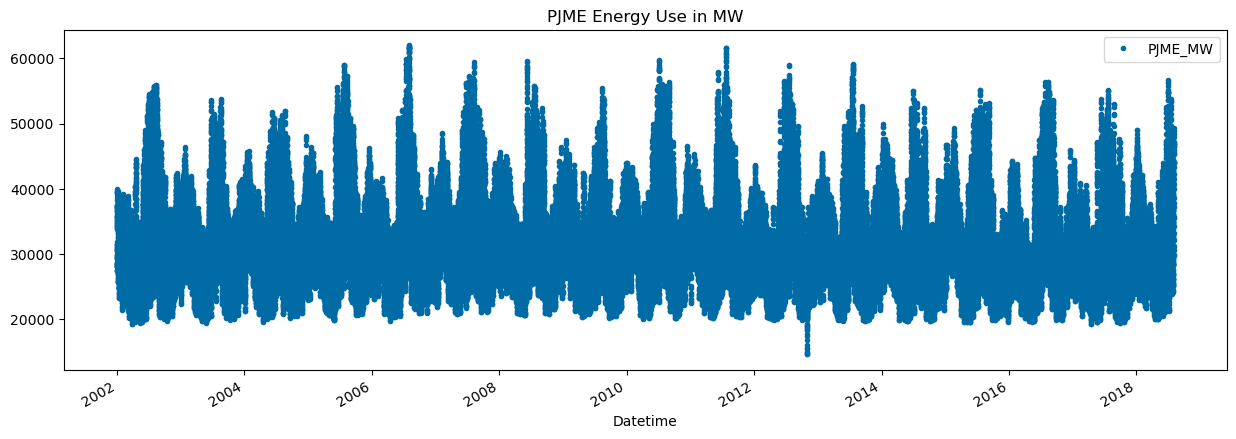

In [25]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

Que observamos en la gráfica?

**Valores faltantes:**

In [26]:
print('Cantidad de NaNs:')
for column in df:
    nans = df[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna PJME_MW: 0


In [27]:
df.tail()

,PJME_MW
Datetime,
2018-08-02 20:00:00,44057.0
2018-08-02 21:00:00,43256.0
2018-08-02 22:00:00,41552.0
2018-08-02 23:00:00,38500.0
2018-08-03 00:00:00,35486.0


**Análisis de Outliers**

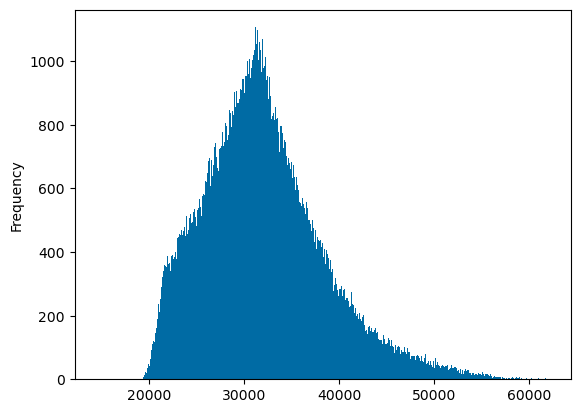

In [28]:
df['PJME_MW'].plot(kind='hist', bins=500);

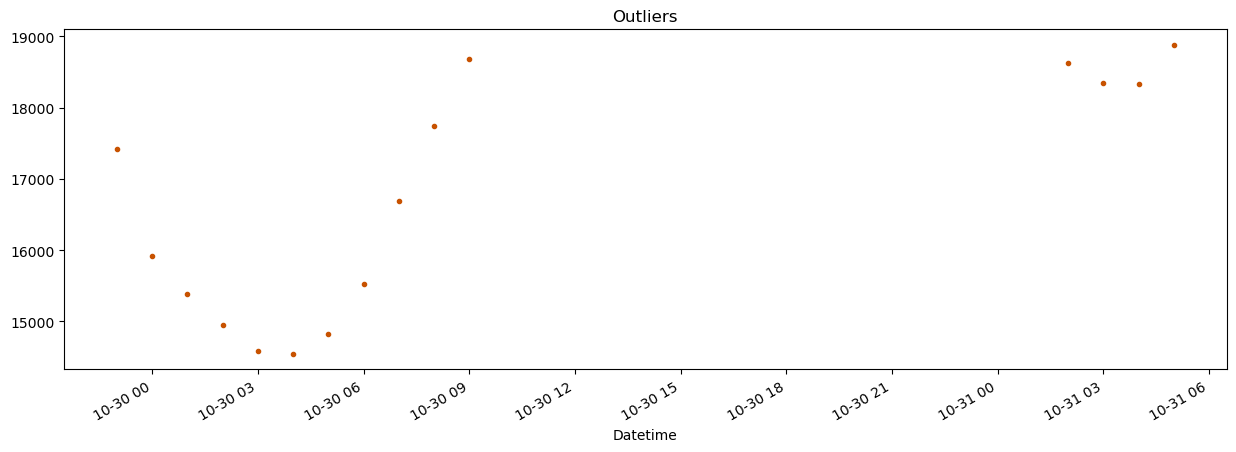

In [29]:
df.query('PJME_MW < 19_000')['PJME_MW'].plot(style='.',figsize=(15, 5), color=color_pal[5],title='Outliers');

In [30]:
#df = df.query('PJME_MW > 19_000').copy()

Se genera un array de números aleatorios uniformemente distribuidos entre 19000 y 20000.

In [31]:
condicion = df['PJME_MW'] < 19000
df.loc[condicion, 'PJME_MW'] = np.random.uniform(19000, 20000, condicion.sum())

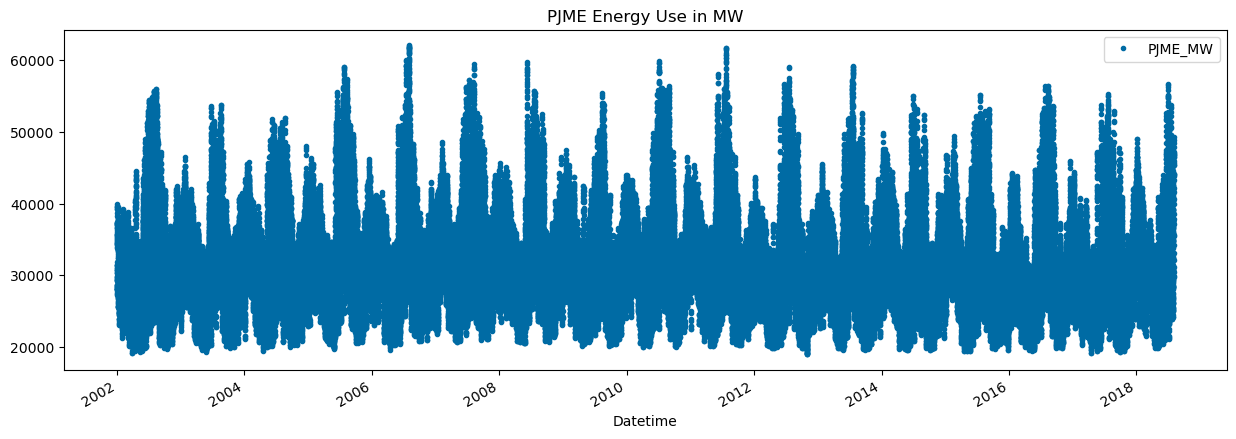

In [32]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

**Separación del dataset en train, test**

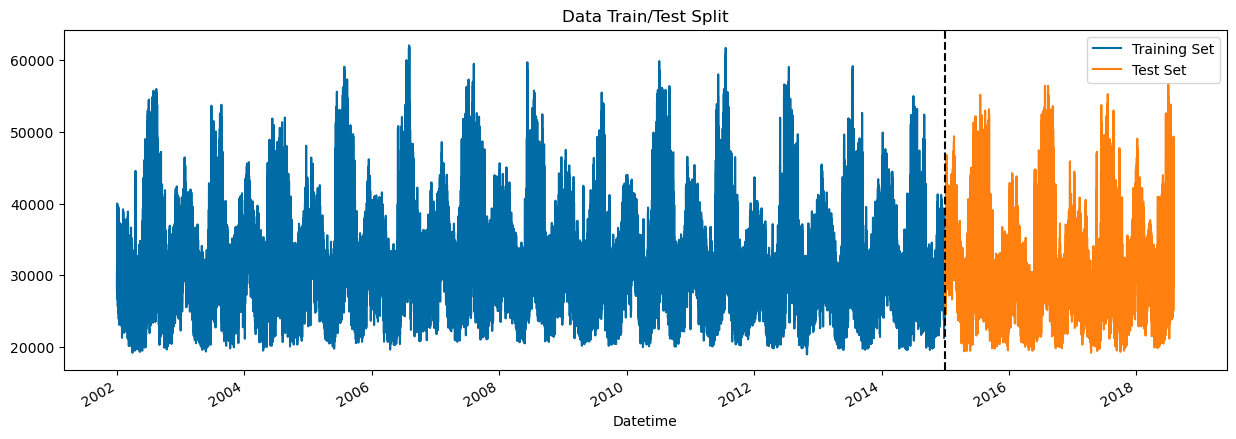

In [33]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

**Cross Validation para Series de Tiempo**

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

La siguiente línea de código crea un objeto de tipo TimeSeriesSplit que se utiliza para dividir una serie temporal en conjuntos de entrenamiento y prueba para su validación cruzada.

n_splits=5: Indica que se dividirá la serie temporal en 5 conjuntos diferentes  

Gap: se asegura que el conjunto de prueba refleje mejor una situación en la que solo se tiene información hasta un cierto punto en el tiempo, y el modelo debe hacer predicciones futuras basadas en ese conocimiento limitado.

In [34]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24) #se están dejando 24 hrs como brecha entre el conjunto de entrenamiento y el conjunto de prueba. (mayor representatividad)
df = df.sort_index()

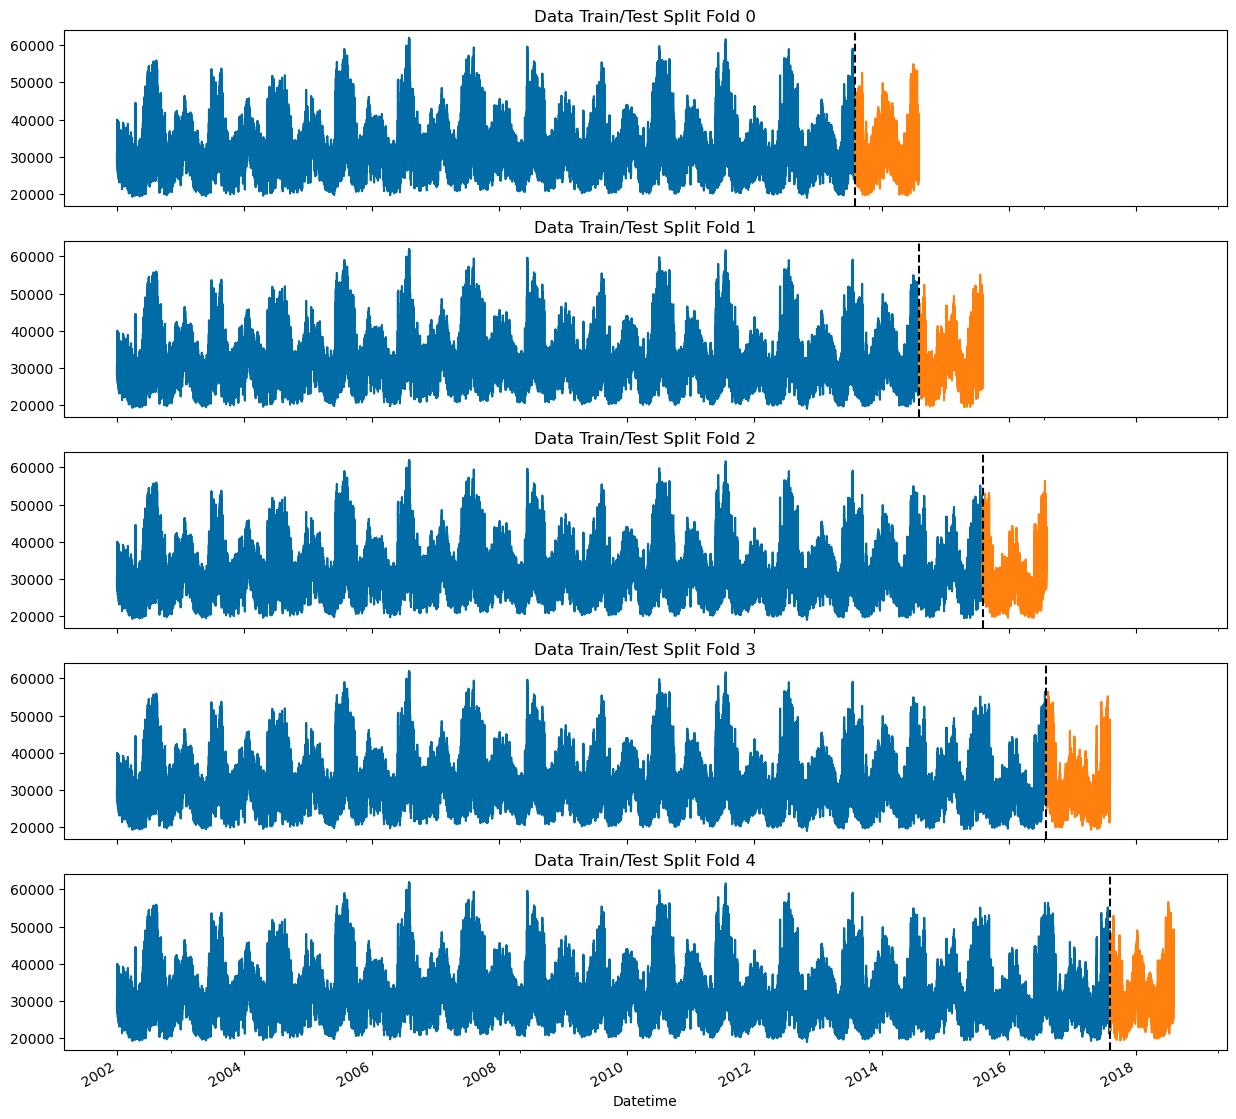

In [35]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    val['PJME_MW'].plot(ax=axs[fold],label='Val Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

Visualizamos la estructura de tss

In [36]:
tss

TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=8760)

In [37]:
for i, (train_index, test_index) in enumerate(tss.split(df)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[     0      1      2 ... 101539 101540 101541]
  Test:  index=[101566 101567 101568 ... 110323 110324 110325]
Fold 1:
  Train: index=[     0      1      2 ... 110299 110300 110301]
  Test:  index=[110326 110327 110328 ... 119083 119084 119085]
Fold 2:
  Train: index=[     0      1      2 ... 119059 119060 119061]
  Test:  index=[119086 119087 119088 ... 127843 127844 127845]
Fold 3:
  Train: index=[     0      1      2 ... 127819 127820 127821]
  Test:  index=[127846 127847 127848 ... 136603 136604 136605]
Fold 4:
  Train: index=[     0      1      2 ... 136579 136580 136581]
  Test:  index=[136606 136607 136608 ... 145363 145364 145365]


**Feature Engineering**

In [38]:
def create_features(df):
    """
    Creamos features basadas en el índice tiempo.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [39]:
df = create_features(df)

Agregamos rezagos de la variable target:

In [40]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [41]:
df = add_lags(df)

In [42]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


**Entrenamiento**

In [43]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

In [44]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    val = df.iloc[val_idx]

    train = create_features(train)
    val = create_features(val)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #utilizar modelado basado en árboles
                           n_estimators=1000, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiendo como el número de iteraciones de boosting.
                           objective='reg:linear', #Aquí es donde se indica si queremos hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            eval_metric=['rmse', 'mae'],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

[15:06:05] WARNING: D:\bld\xgboost-split_1700182179651\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32730.92562	validation_0-mae:32087.38052	validation_1-rmse:31956.74553	validation_1-mae:31369.01952


c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

[100]	validation_0-rmse:12531.90955	validation_0-mae:11746.13526	validation_1-rmse:11910.56294	validation_1-mae:11195.21223
[200]	validation_0-rmse:5741.99364	validation_0-mae:4506.12562	validation_1-rmse:5356.26525	validation_1-mae:4252.70518
[300]	validation_0-rmse:3867.70663	validation_0-mae:2726.23072	validation_1-rmse:3896.32853	validation_1-mae:2875.95081
[400]	validation_0-rmse:3431.16439	validation_0-mae:2465.01048	validation_1-rmse:3758.10766	validation_1-mae:2801.57164
[500]	validation_0-rmse:3314.53102	validation_0-mae:2420.50035	validation_1-rmse:3772.89798	validation_1-mae:2822.96072
[600]	validation_0-rmse:3257.76901	validation_0-mae:2393.80270	validation_1-rmse:3786.32780	validation_1-mae:2833.71398
[700]	validation_0-rmse:3217.47552	validation_0-mae:2371.23206	validation_1-rmse:3794.63523	validation_1-mae:2840.31134
[800]	validation_0-rmse:3184.08859	validation_0-mae:2347.88275	validation_1-rmse:3803.95210	validation_1-mae:2844.31499
[900]	validation_0-rmse:3153.95376	v

c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

[100]	validation_0-rmse:12513.09276	validation_0-mae:11725.37450	validation_1-rmse:12221.98037	validation_1-mae:11494.25914
[200]	validation_0-rmse:5755.80198	validation_0-mae:4509.92850	validation_1-rmse:5654.37976	validation_1-mae:4429.08633
[300]	validation_0-rmse:3904.80841	validation_0-mae:2754.45824	validation_1-rmse:3929.49527	validation_1-mae:2812.21773
[400]	validation_0-rmse:3477.52996	validation_0-mae:2500.75418	validation_1-rmse:3598.92826	validation_1-mae:2628.26984
[500]	validation_0-rmse:3356.13238	validation_0-mae:2450.73630	validation_1-rmse:3530.15263	validation_1-mae:2596.08107
[600]	validation_0-rmse:3300.22903	validation_0-mae:2427.79136	validation_1-rmse:3491.86921	validation_1-mae:2570.96962
[700]	validation_0-rmse:3259.88349	validation_0-mae:2403.75162	validation_1-rmse:3464.64338	validation_1-mae:2542.42600
[800]	validation_0-rmse:3224.91943	validation_0-mae:2379.44265	validation_1-rmse:3443.26758	validation_1-mae:2507.15544
[900]	validation_0-rmse:3197.56226	v

c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

[100]	validation_0-rmse:12498.11644	validation_0-mae:11711.12746	validation_1-rmse:11136.38288	validation_1-mae:10297.21486
[200]	validation_0-rmse:5749.81724	validation_0-mae:4504.01192	validation_1-rmse:4815.12814	validation_1-mae:3528.43460
[300]	validation_0-rmse:3915.59997	validation_0-mae:2762.42569	validation_1-rmse:3548.34629	validation_1-mae:2568.71678
[400]	validation_0-rmse:3493.84576	validation_0-mae:2512.82128	validation_1-rmse:3489.90699	validation_1-mae:2671.46147
[500]	validation_0-rmse:3378.69896	validation_0-mae:2468.02020	validation_1-rmse:3545.75282	validation_1-mae:2773.39733
[600]	validation_0-rmse:3320.92546	validation_0-mae:2441.59420	validation_1-rmse:3598.95859	validation_1-mae:2834.89940
[700]	validation_0-rmse:3280.30504	validation_0-mae:2417.94637	validation_1-rmse:3628.27072	validation_1-mae:2868.42229
[800]	validation_0-rmse:3250.07877	validation_0-mae:2397.37256	validation_1-rmse:3656.85104	validation_1-mae:2904.84911
[900]	validation_0-rmse:3224.11343	v

c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

[100]	validation_0-rmse:12461.45765	validation_0-mae:11671.76002	validation_1-rmse:12020.45996	validation_1-mae:11102.81434
[200]	validation_0-rmse:5736.17954	validation_0-mae:4495.08207	validation_1-rmse:5796.65736	validation_1-mae:4279.55065
[300]	validation_0-rmse:3911.96540	validation_0-mae:2764.62473	validation_1-rmse:4386.37902	validation_1-mae:3021.80416
[400]	validation_0-rmse:3494.82677	validation_0-mae:2517.16473	validation_1-rmse:4175.68318	validation_1-mae:2976.46730
[500]	validation_0-rmse:3380.89018	validation_0-mae:2473.37017	validation_1-rmse:4120.76146	validation_1-mae:2967.27052
[600]	validation_0-rmse:3321.91577	validation_0-mae:2447.42283	validation_1-rmse:4112.07279	validation_1-mae:2962.64171
[700]	validation_0-rmse:3281.17443	validation_0-mae:2422.50873	validation_1-rmse:4097.26026	validation_1-mae:2946.28149
[800]	validation_0-rmse:3249.16039	validation_0-mae:2400.75924	validation_1-rmse:4096.96146	validation_1-mae:2943.55101
[900]	validation_0-rmse:3221.71926	v

c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

[100]	validation_0-rmse:12444.77666	validation_0-mae:11645.89743	validation_1-rmse:11960.52197	validation_1-mae:11213.08193
[200]	validation_0-rmse:5750.24147	validation_0-mae:4492.22249	validation_1-rmse:5613.04911	validation_1-mae:4479.35619
[300]	validation_0-rmse:3949.46186	validation_0-mae:2788.14369	validation_1-rmse:4152.78735	validation_1-mae:3061.77712
[400]	validation_0-rmse:3539.57700	validation_0-mae:2547.58103	validation_1-rmse:4002.46677	validation_1-mae:2933.57246
[500]	validation_0-rmse:3429.11128	validation_0-mae:2505.14021	validation_1-rmse:4025.50485	validation_1-mae:2944.94146
[600]	validation_0-rmse:3373.35345	validation_0-mae:2479.73160	validation_1-rmse:4055.35404	validation_1-mae:2968.66342
[700]	validation_0-rmse:3335.51459	validation_0-mae:2457.29442	validation_1-rmse:4055.94499	validation_1-mae:2968.85668
[800]	validation_0-rmse:3306.98914	validation_0-mae:2437.75220	validation_1-rmse:4048.35484	validation_1-mae:2963.42229
[900]	validation_0-rmse:3280.23431	v

c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

In [45]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3802.4364
Fold scores:[3782.166743301954, 3426.985195420423, 3710.7918249121894, 4066.800250797348, 4025.437898161024]


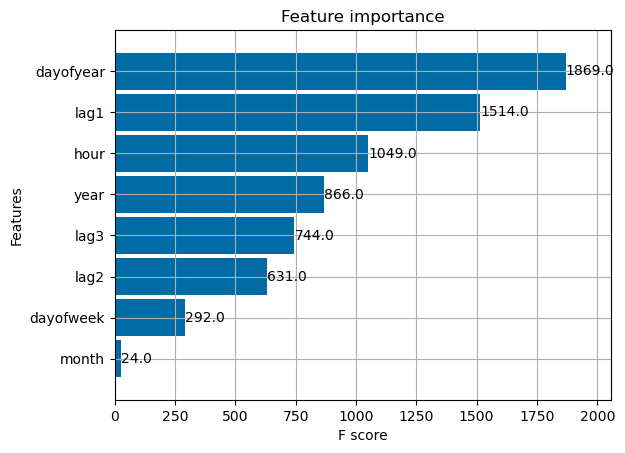

In [46]:
_ = plot_importance(reg, height=0.9)

**Pronostico sobre los datos de Test**

In [47]:
y_pred = reg.predict(X_val)

c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

In [48]:
y_pred

array([29258.057, 28234.41 , 27455.49 , ..., 39463.824, 36677.82 ,
       31565.92 ], dtype=float32)

Adicionamos la predicción al set de Validación

In [49]:
val['prediction'] = reg.predict(X_val)

c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\waldo\miniforge3\envs\uni\lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

In [50]:
val['prediction']

Datetime
2017-08-03 01:00:00    29258.056641
2017-08-03 02:00:00    28234.410156
2017-08-03 03:00:00    27455.490234
2017-08-03 04:00:00    26833.513672
2017-08-03 05:00:00    26848.976562
                           ...     
2018-08-02 20:00:00    42709.535156
2018-08-02 21:00:00    41688.250000
2018-08-02 22:00:00    39463.824219
2018-08-02 23:00:00    36677.820312
2018-08-03 00:00:00    31565.919922
Name: prediction, Length: 8760, dtype: float32

In [51]:
val

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,prediction
Datetime,,,,,,,,,,,,,
2017-08-03 01:00:00,29189.0,1,3,3,8,2017,215,3,31,28809.0,29952.0,28465.0,29258.056641
2017-08-03 02:00:00,27584.0,2,3,3,8,2017,215,3,31,27039.0,27934.0,26712.0,28234.410156
2017-08-03 03:00:00,26544.0,3,3,3,8,2017,215,3,31,25881.0,26659.0,25547.0,27455.490234
2017-08-03 04:00:00,26012.0,4,3,3,8,2017,215,3,31,25300.0,25846.0,24825.0,26833.513672
2017-08-03 05:00:00,26187.0,5,3,3,8,2017,215,3,31,25412.0,25898.0,24927.0,26848.976562
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0,42709.535156
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0,41688.250000
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0,39463.824219


**Visualización de la predicción y los datos originales:**

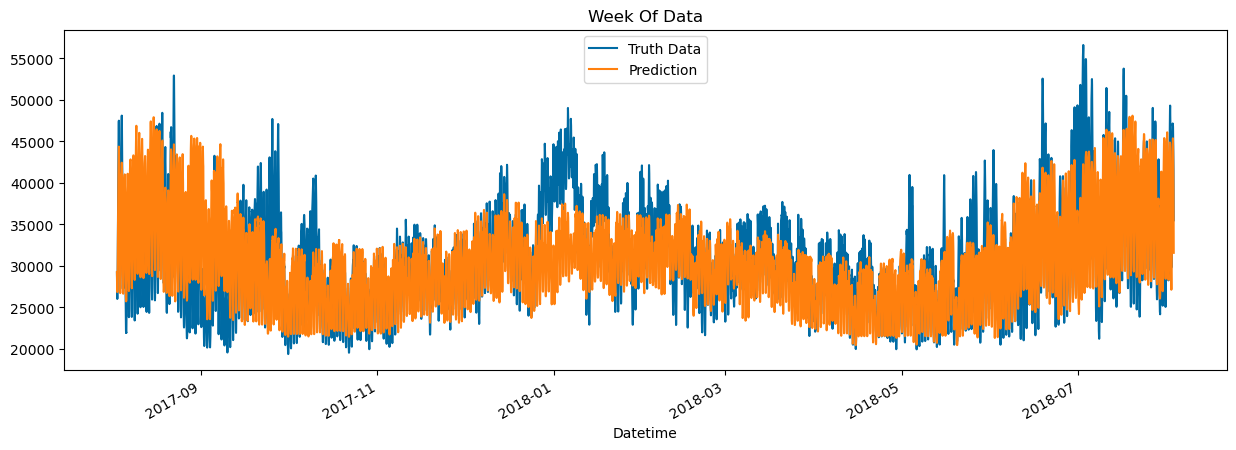

In [52]:
ax = val.loc[(val.index >= '2017-08-03')]['PJME_MW'].plot(figsize=(15, 5), title='Week Of Data')
val.loc[(val.index >= '2017-08-03')]['prediction'].plot()
plt.legend(['Truth Data','Prediction'])
plt.show()

**Métricas de performance:**

In [53]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Calculate error metrics using the filtered data
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
score = np.sqrt(mean_squared_error(y_val, y_pred))

In [54]:
# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 16204150.27195104
Mean Absolute Error (MAE): 2950.980233081835
RMSE Score on Test set: 4025.44
